# ロジスティック回帰

ロジスティック回帰の例として，学生がある大学に入学できるかを2つの試験の点数から予測する問題を扱う．過去の出願者に対する2つの試験の点数と入学許可の有無を訓練データとして用いる．

## データのロード

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

In [3]:
# 訓練データのロード
# 0列目：試験1の点数，1列目：試験2の点数，2列目：入学許可の有無（合格が1，不合格が0）
data = np.loadtxt('data/ex2data1.txt',delimiter=',')
X_unext = np.array(data[:,0:-1]) # 特徴量を各出願者について縦に並べた行列
y = np.array(data[:,[-1]]) # ターゲットを各出願者について縦に並べた列ベクトル
m, n = X_unext.shape
print('訓練データの数：m =',m)
print('特徴量の数：n =',n)

訓練データの数：m = 100
特徴量の数：n = 2


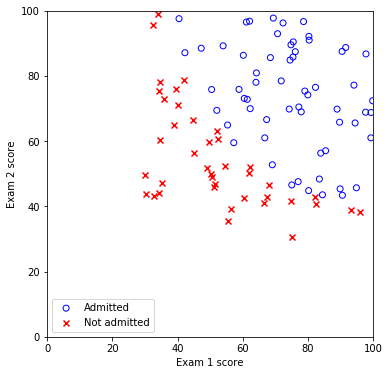

In [157]:
# 訓練データのプロット
I_y1 = (y == 1).flatten() # 合格者の論理インデックス
I_y0 = (y == 0).flatten() # 不合格者の論理インデックス
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(X_unext[I_y1,0],X_unext[I_y1,1],marker='o',facecolors='none', edgecolors='b',label='Admitted')
ax.scatter(X_unext[I_y0,0],X_unext[I_y0,1],marker='x',color='r',label='Not admitted')
ax.set_xlim([0,100])
ax.set_ylim([0,100])
ax.set_xlabel('Exam 1 score')
ax.set_ylabel('Exam 2 score')
ax.legend()
ax.set_aspect('equal')

## 仮説とコスト関数の定義

特徴量ベクトルを$x=(x_0 ,x_1 ,\dots ,x_n)^\mathrm{T} \in\mathbb{R}^{n+1}$，ターゲットを$y\in\{0,1\}$とする．ただし，0番目の特徴量は常に$x_0 =1$とする．特徴量とターゲットの組$(x,y)$は何らかの真の分布$p(x,y)=p(x)p(y\vert x)$に従う．特徴量$x$が与えられたときのターゲット$y$の分布$p(y\vert x)$を推定したい．パラメータ$\theta =(\theta ^0 ,\theta ^1 ,\dots ,\theta ^n)^\mathrm{T}$に対して仮説を
$$
h_\theta (x)=\sigma (x^\mathrm{T} \theta )
$$
とする．ここで，
$$
\sigma (z)=\frac{1}{1+e^{-z}}
$$
はシグモイド関数と呼ばれ，$\lim _{z\to -\infty} \sigma (z)=0$, $\sigma (0)=1/2$, $\lim _{z\to\infty} \sigma (z)=1$を満たす単調増加関数である．ロジスティック回帰では，特徴量$x$が与えられたときターゲットが$y=1$となる確率が仮説$h_\theta (x)$であると推定する．このとき$y=0$となる確率は$1-h_\theta (x)$となる．したがって，パラメータが$\theta$のとき与えられた特徴量$x$に対するターゲット$y$の分布は
$$
p(y\vert x,\theta )=yh_\theta (x)+(1-y)(1-h_\theta (x))=\left\{
\begin{alignedat}{2}
& 1-h_\theta (x),\quad && y=0, \\
& h_\theta (x),\quad && y=1
\end{alignedat}
\right.
$$
となる．

真の分布$p(x,y)$と推定される分布$p(x,y\vert\theta )=p(x)p(y\vert x,\theta )$をなるべく近づけたいので，これらの間のKullback-Leipler (KL) ダイバージェンス
$$
\mathrm{E}_{p(x,y)} \left[\log\frac{p(x,y)}{p(x,y\vert\theta )} \right] =\mathrm{E}_{p(x,y)} \left[\log\frac{p(y\vert x)}{p(y\vert x,\theta )} \right] =\mathrm{E}_{p(x,y)} [\log p(y\vert x)]-\mathrm{E}_{p(x,y)} [\log p(y\vert x,\theta )]
$$
を小さくすればよい．$\mathrm{E}_{p(x,y)} [\cdot ]$は分布$p(x,y)$に関する期待値である．上式最右辺の第1項は$\theta$によらない定数なので，第2項をコスト関数$J(\theta )$とする：
$$
J(\theta )=-\mathrm{E}_{p(x,y)} [\log p(y\vert x,\theta )].
$$
$J(\theta )$は2つの分布$p(x,y)$, $p(x,y\vert\theta )$の交差エントロピーと呼ばれる．

対数尤度は
$$
\log p(y\vert x,\theta )=y\log h_\theta (x)+(1-y)\log (1-h_\theta (x))=\left\{
\begin{alignedat}{2}
& \log (1-h_\theta (x)),\quad && y=0, \\
& \log h_\theta (x),\quad && y=1
\end{alignedat}
\right.
$$
と書けるので，コスト関数は次のように表される：
$$
J(\theta )=-\mathrm{E}_{p(x,y)} [y\log h_\theta (x)+(1-y)\log (1-h_\theta (x))]\approx -\frac{1}{m} \sum _{d=1}^m [y^{(d)} \log h_\theta (x^{(d)})+(1-y^{(d)})\log (1-h_\theta (x^{(d)}))].
$$
ここで，真の分布$p(x,y)$はわからないので期待値を訓練データ$(d)$ ($d=1,\dots ,m$) に関する平均値で近似した．

後で勾配法を用いるためコスト関数の勾配を求めておく．シグモイド関数の導関数が
$$
\sigma '(z)=\sigma (z)(1-\sigma (z))
$$
であることに注意すると，コスト関数の勾配は次のように表される：
$$
\frac{\partial J(\theta )}{\partial\theta} =\mathrm{E}_{p(x,y)} [(h_\theta (x)-y)x]\approx\frac{1}{m} \sum _{d=1}^m (h_\theta (x^{(d)})-y^{(d)})x^{(d)} .
$$

In [5]:
# 0番目の特徴量1を追加する関数
# X_unextは追加前のm*n行列，Xは追加後のm*(n+1)行列（特徴量の行ベクトルを縦に並べたもの）
def add1column(X_unext):
    X = np.insert(X_unext,0,1,axis=1)
    return(X)

In [6]:
# 特徴量行列
X = add1column(X_unext)

In [7]:
# シグモイド関数
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return(s)

In [8]:
# コスト関数と勾配
def costFunction_gradient(X,y,theta):
    epsilon = 1e-7 # np.log(0) の発散を防ぐ
    m = y.size
    h = sigmoid(X @ theta)
    J = -(1 / m) * np.squeeze((y.T @ np.log(h+epsilon) + (1-y).T @ np.log(1-h+epsilon)))
    J_theta = (1 / m) * X.T @ (h - y)
    return(J,J_theta)

In [9]:
# 初期パラメータでコスト関数を評価
thetai = np.zeros((n+1,1)) # 初期パラメータ（ゼロベクトル）
Ji, _ = costFunction_gradient(X,y,thetai)
print(Ji)

0.6931469805599655


## 勾配法

勾配法では，コスト関数の勾配と逆方向にパラメータを動かすことでコスト関数の最小点を探索する．勾配法の更新式は次のように与えられる：
$$
\theta\leftarrow\theta -\alpha\frac{\partial J(\theta )}{\partial\theta} .
$$
$\alpha$は学習率と呼ばれる．

In [10]:
# 勾配法
def gradientDescent(X,y,thetai,alpha=0.01,num_iters=2000):
    theta = thetai
    J_theta = 0
    theta_history = np.zeros((theta.size,num_iters+1))
    J_history = np.zeros((num_iters+1))
    
    for i in np.arange(num_iters+1):
        theta = theta - alpha * J_theta
        theta_history[:,[i]] = theta
        J_history[i], J_theta = costFunction_gradient(X,y,theta)
    
    return(theta,theta_history,J_history)

しかし，学習率$\alpha =10^{-3}$で勾配法を実行すると，更新回数$10^6$でも収束しないことがわかる．

勾配法実行後のパラメータ theta = [-15.39517866   0.12825989   0.12247929]


Text(0.5, 0, '$\\theta _2$')

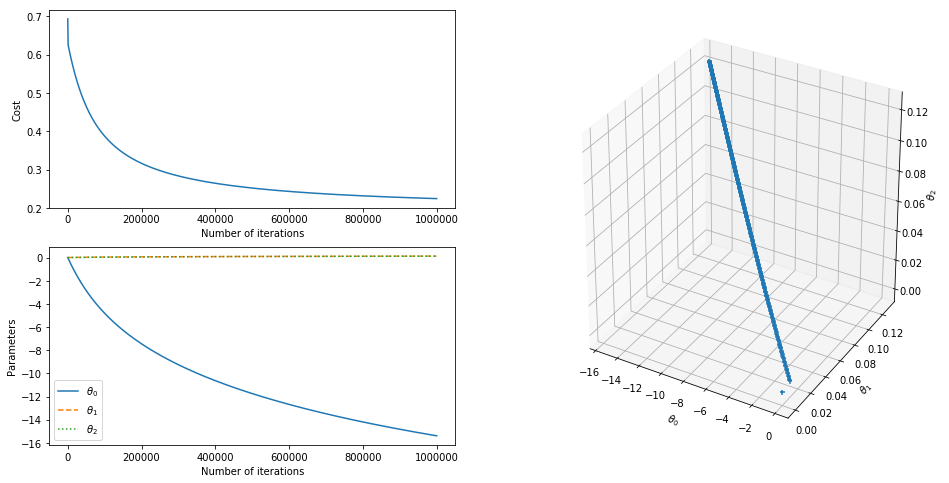

In [11]:
# 勾配法の実行
theta, theta_history, J_history = gradientDescent(X,y,thetai,alpha=1e-3,num_iters=int(1e+6))
print('勾配法実行後のパラメータ theta =',theta.flatten())

# パラメータ更新1000回ごとのコスト，パラメータをプロット
t = np.arange(0,J_history.size+1,1000)
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(t,J_history[t])
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = plt.subplot(gs[1,0])
ax2.plot(t,theta_history[0,t],'-',label=r'$\theta_0$')
ax2.plot(t,theta_history[1,t],'--',label=r'$\theta_1$')
ax2.plot(t,theta_history[2,t],':',label=r'$\theta_2$')
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax2.legend()
ax3 = plt.subplot(gs[:,1],projection='3d')
ax3.scatter3D(theta_history[0,t],theta_history[1,t],theta_history[2,t],marker='+')
ax3.set_xlabel(r'$\theta _0$')
ax3.set_ylabel(r'$\theta _1$')
ax3.set_zlabel(r'$\theta _2$')

一方，学習率を$\alpha =3\times 10^{-3}$とすると，勾配法によるパラメータの動きは激しく振動してしまう．

勾配法実行後のパラメータ theta = [-0.45809596  0.02346135 -0.06685191]


Text(0.5, 0, '$\\theta _2$')

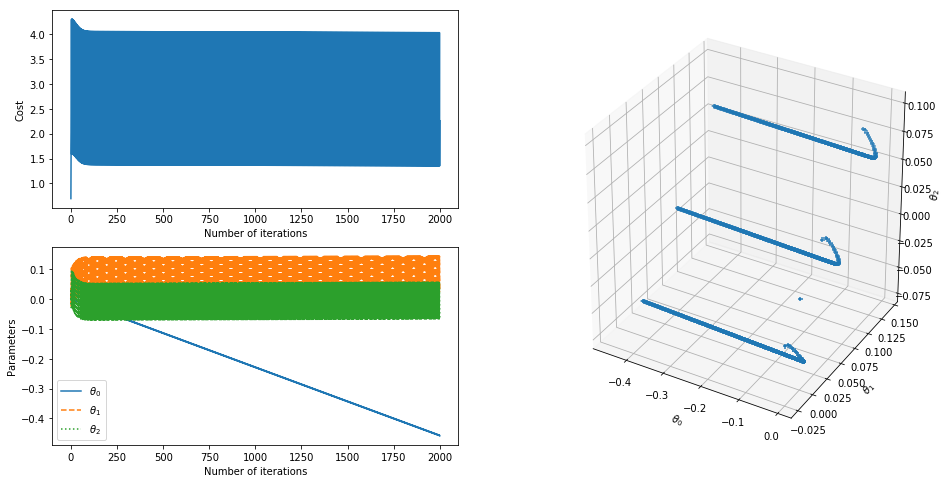

In [12]:
# 勾配法の実行
theta, theta_history, J_history = gradientDescent(X,y,thetai,alpha=3e-3)
print('勾配法実行後のパラメータ theta =',theta.flatten())

# パラメータ更新ごとのコスト，パラメータをプロット
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(J_history)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = plt.subplot(gs[1,0])
ax2.plot(theta_history[0,:],'-',label=r'$\theta_0$')
ax2.plot(theta_history[1,:],'--',label=r'$\theta_1$')
ax2.plot(theta_history[2,:],':',label=r'$\theta_2$')
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax2.legend()
ax3 = plt.subplot(gs[:,1],projection='3d')
ax3.scatter3D(theta_history[0,:],theta_history[1,:],theta_history[2,:],marker='+')
ax3.set_xlabel(r'$\theta _0$')
ax3.set_ylabel(r'$\theta _1$')
ax3.set_zlabel(r'$\theta _2$')

## 自然勾配法

勾配法はうまくいかない（もしくは非常に効率が悪い）ことがわかったので，自然勾配法を試してみよう．自然勾配法の更新式は次のように与えられる：
$$
\theta\leftarrow\theta -\alpha g(\theta )^{-1} \frac{\partial J(\theta )}{\partial\theta} .
$$
$g(\theta )$はFisher情報行列であり，$(i,j)$成分は次のように定義される：
$$
g_{ij} (\theta )=-\mathrm{E}_{p(x,y\vert\theta )} [\partial _i \partial _j \log p(x,y\vert\theta )]=\mathrm{E}_{p(x,y\vert\theta )} [\partial _i \log p(x,y\vert\theta )\,\partial _j \log p(x,y\vert\theta )].
$$
ただし，$\partial _i =\partial /\partial\theta ^i$である．$g^{-1} (\theta )$の$(i,j)$成分を$g^{ij} (\theta )$と書き，$\partial ^i =g^{ij} (\theta )\partial _j$（Einsteinの縮約規則を用いる）と定義すると，自然勾配法の更新式は成分表示で次のように表される：
$$
\theta ^i \leftarrow\theta ^i -g^{ij} (\theta )\partial _j J(\theta )=\theta ^i -\alpha\partial ^i J(\theta ).
$$

Fisher情報行列を計算しよう．$\log p(x,y\vert\theta )=\log p(x)+\log p(y\vert x,\theta )$および
\begin{align*}
\log p(y\vert x,\theta ) & =y\log h_\theta (x)+(1-y)\log (1-h_\theta (x)), \\
\partial _i \log p(y\vert x,\theta ) & =-(h_\theta (x)-y)x_i , \\
\partial _i \partial _j \log p(y\vert x,\theta ) & =-\sigma '(x^\mathrm{T} \theta )x_i x_j =-h_\theta (x)(1-h_\theta (x))x_i x_j
\end{align*}
から
$$
g_{ij} (\theta )=\mathrm{E}_{p(x,y\vert\theta )} [h_\theta (x)(1-h_\theta (x))x_i x_j]=\mathrm{E}_{p(x)} [h_\theta (x)(1-h_\theta (x))x_i x_j]
$$
となる．特徴量の事前分布$p(x)$はわからないので，期待値を訓練データに関する平均値で近似すると，
$$
g_{ij} (\theta )=\frac{1}{m} \sum _{d=1}^m h_\theta (x^{(d)})(1-h_\theta (x^{(d)}))x_i^{(d)} x_j^{(d)}
$$
すなわち
$$
g(\theta )=\frac{1}{m} \sum _{d=1}^m h_\theta (x^{(d)})(1-h_\theta (x^{(d)}))x^{(d)} (x^{(d)})^\mathrm{T}
$$
が得られる．

In [13]:
# Fisher情報行列
def FisherMatrix(X,theta):
    m = X.shape[0]
    h = sigmoid(X @ theta)
    h_d1 = h * (1 - h)
    g = (1 / m) * np.einsum('dt,di,dj->tij',h_d1,X,X)
    return(g)

In [14]:
# 自然勾配法
def naturalGradientDescent(X,y,thetai,alpha=0.01,num_iters=2000):
    theta = thetai
    J_theta_n = 0
    theta_history = np.zeros((theta.size,num_iters+1))
    J_history = np.zeros((num_iters+1))
    
    for i in np.arange(num_iters+1):
        theta = theta - alpha * J_theta_n
        theta_history[:,[i]] = theta
        J_history[i], J_theta = costFunction_gradient(X,y,theta)
        g_inv = np.linalg.inv(FisherMatrix(X,theta))
        J_theta_n = np.einsum('tij,jt->it',g_inv,J_theta)
    
    return(theta,theta_history,J_history)

学習率$\alpha =0.01$，更新回数2,000で自然勾配法を実行すると，コストとパラメータはきちんと収束することがわかる．

自然勾配法実行後のパラメータ theta = [-25.16133301   0.20623171   0.2014716 ]


Text(0.5, 0, '$\\theta _2$')

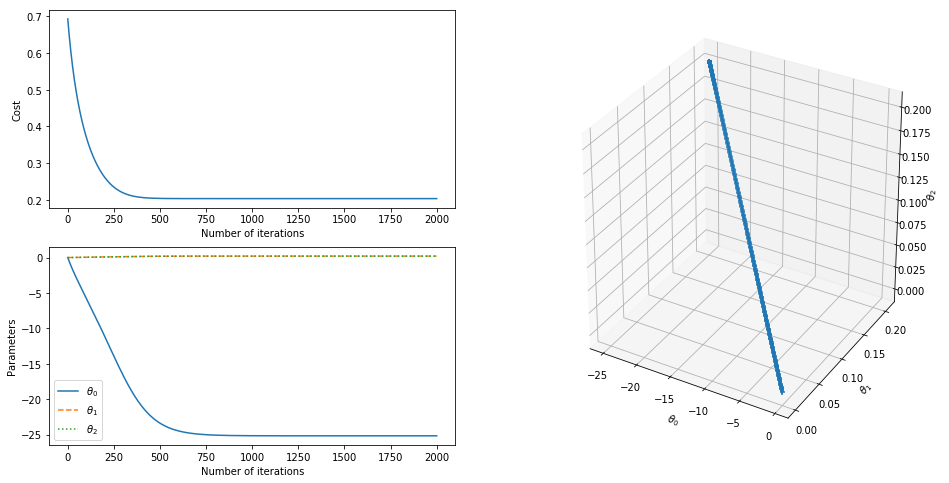

In [15]:
# 自然勾配法の実行
theta, theta_history, J_history = naturalGradientDescent(X,y,thetai)
print('自然勾配法実行後のパラメータ theta =',theta.flatten())

# パラメータ更新ごとのコスト，パラメータをプロット
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(J_history)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = plt.subplot(gs[1,0])
ax2.plot(theta_history[0,:],'-',label=r'$\theta_0$')
ax2.plot(theta_history[1,:],'--',label=r'$\theta_1$')
ax2.plot(theta_history[2,:],':',label=r'$\theta_2$')
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax2.legend()
ax3 = plt.subplot(gs[:,1],projection='3d')
ax3.scatter3D(theta_history[0,:],theta_history[1,:],theta_history[2,:],marker='+')
ax3.set_xlabel(r'$\theta _0$')
ax3.set_ylabel(r'$\theta _1$')
ax3.set_zlabel(r'$\theta _2$')

なお，学習率を$\alpha =1$とすると10ステップ程度で収束する．

自然勾配法実行後のパラメータ theta = [-25.16133357   0.20623171   0.2014716 ]


Text(0.5, 0, '$\\theta _2$')

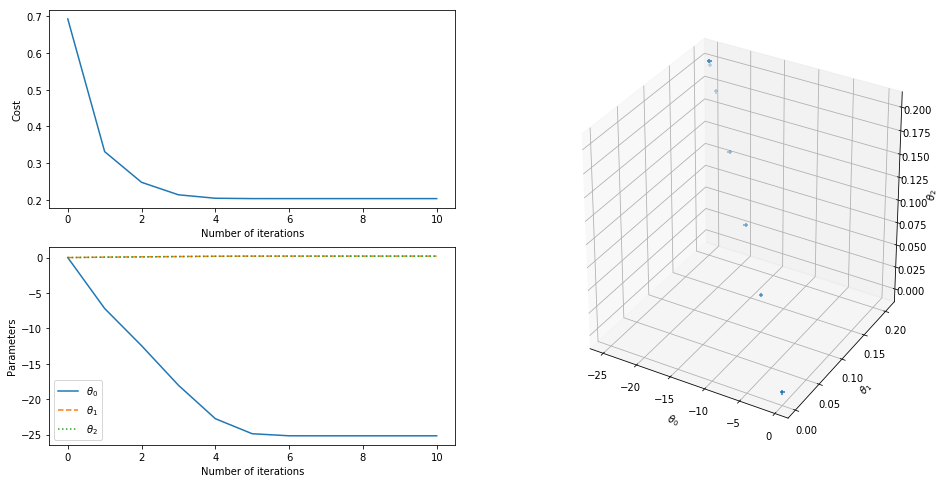

In [16]:
# 自然勾配法の実行
theta, theta_history, J_history = naturalGradientDescent(X,y,thetai,alpha=1,num_iters=10)
print('自然勾配法実行後のパラメータ theta =',theta.flatten())

# パラメータ更新ごとのコスト，パラメータをプロット
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(J_history)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = plt.subplot(gs[1,0])
ax2.plot(theta_history[0,:],'-',label=r'$\theta_0$')
ax2.plot(theta_history[1,:],'--',label=r'$\theta_1$')
ax2.plot(theta_history[2,:],':',label=r'$\theta_2$')
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax2.legend()
ax3 = plt.subplot(gs[:,1],projection='3d')
ax3.scatter3D(theta_history[0,:],theta_history[1,:],theta_history[2,:],marker='+')
ax3.set_xlabel(r'$\theta _0$')
ax3.set_ylabel(r'$\theta _1$')
ax3.set_zlabel(r'$\theta _2$')

## 決定境界と正解率

In [17]:
# 予測
# thetaが（自然）勾配法の更新履歴の場合ypは各ステップでの各データに対する予測になる
def predict(X,theta):
    h = sigmoid(X @ theta)
    yp = np.minimum(np.floor(2*h),1)
    return(yp)

In [18]:
# 予測と正解率
# thetaが（自然）勾配法の更新履歴の場合accは各ステップでの正解率になる
def predict_accuracy(X,y,theta):
    m = y.size
    yp = predict(X,theta)
    I_True = (yp == y).astype('float')
    acc = np.sum(I_True,axis=0) / m
    return(yp,acc)

In [19]:
# 訓練データに対する正解率
_, acc_history = predict_accuracy(X,y,theta_history)
print('自然勾配法での最終的な正解率',acc_history[-1])

自然勾配法での最終的な正解率 0.89


Text(0, 0.5, 'Accuracy')

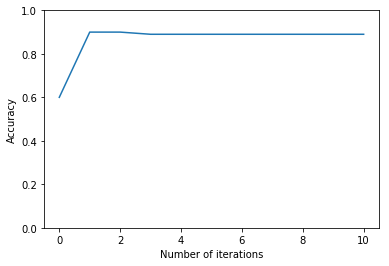

In [20]:
# 正解率のプロット
plt.plot(acc_history)
plt.ylim([0,1])
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')

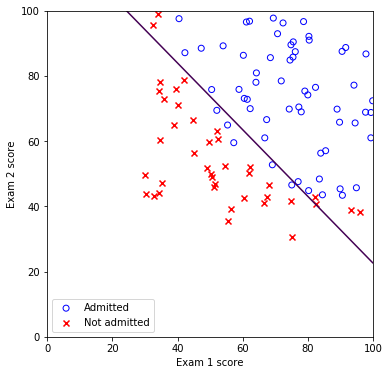

In [21]:
# 特徴量の格子点上で仮説の値を計算
x1v = np.linspace(0,100)
x2v = np.linspace(0,100)
x1g, x2g = np.meshgrid(x1v,x2v)
hg = sigmoid(add1column(np.array([x1g.reshape(-1),x2g.reshape(-1)]).T) @ theta).reshape(x1g.shape)

# 決定境界のプロット
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(X_unext[I_y1,0],X_unext[I_y1,1],marker='o',facecolors='none', edgecolors='b',label='Admitted')
ax.scatter(X_unext[I_y0,0],X_unext[I_y0,1],marker='x',color='r',label='Not admitted')
ax.contour(x1g,x2g,hg,levels=np.array([0.5]))
ax.set_xlim([0,100])
ax.set_ylim([0,100])
ax.set_xlabel('Exam 1 score')
ax.set_ylabel('Exam 2 score')
ax.legend()
ax.set_aspect('equal')

## 勾配法と自然勾配法における勾配と自然勾配

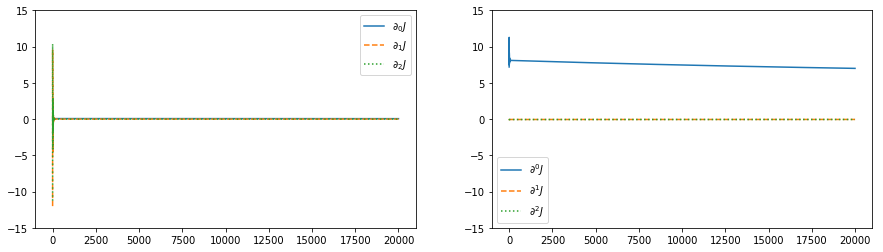

In [22]:
# 勾配法の実行
_, theta_history, _ = gradientDescent(X,y,thetai,alpha=0.001,num_iters=20000)

# 勾配法における勾配と自然勾配の計算
_, J_theta_history = costFunction_gradient(X,y,theta_history)
g_inv_history = np.linalg.inv(FisherMatrix(X,theta_history))
J_theta_n_history = np.einsum('tij,jt->it',g_inv_history,J_theta_history)

# プロット
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(121)
ax1.plot(J_theta_history[0,:],'-',label=r'$\partial _0 J$')
ax1.plot(J_theta_history[1,:],'--',label=r'$\partial _1 J$')
ax1.plot(J_theta_history[2,:],':',label=r'$\partial _2 J$')
ax1.set_ylim([-15,15])
ax1.legend()
ax2 = fig.add_subplot(122)
ax2.plot(J_theta_n_history[0,:],'-',label=r'$\partial ^0 J$')
ax2.plot(J_theta_n_history[1,:],'--',label=r'$\partial ^1 J$')
ax2.plot(J_theta_n_history[2,:],':',label=r'$\partial ^2 J$')
ax2.set_ylim([-15,15])
ax2.legend()

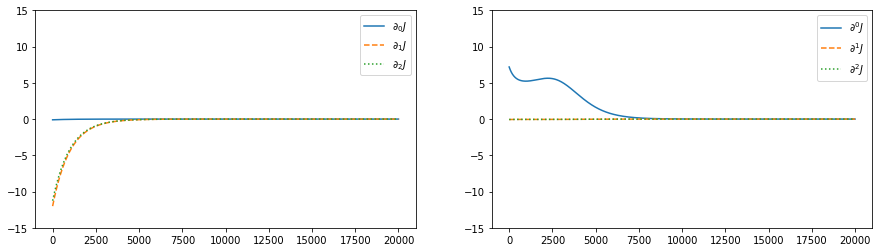

In [23]:
# 自然勾配法の実行
_, theta_history, _ = naturalGradientDescent(X,y,thetai,alpha=0.001,num_iters=20000)

# 自然勾配法における勾配と自然勾配の計算
_, J_theta_history = costFunction_gradient(X,y,theta_history)
g_inv_history = np.linalg.inv(FisherMatrix(X,theta_history))
J_theta_n_history = np.einsum('tij,jt->it',g_inv_history,J_theta_history)

# プロット
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(121)
ax1.plot(J_theta_history[0,:],'-',label=r'$\partial _0 J$')
ax1.plot(J_theta_history[1,:],'--',label=r'$\partial _1 J$')
ax1.plot(J_theta_history[2,:],':',label=r'$\partial _2 J$')
ax1.set_ylim([-15,15])
ax1.legend()
ax2 = fig.add_subplot(122)
ax2.plot(J_theta_n_history[0,:],'-',label=r'$\partial ^0 J$')
ax2.plot(J_theta_n_history[1,:],'--',label=r'$\partial ^1 J$')
ax2.plot(J_theta_n_history[2,:],':',label=r'$\partial ^2 J$')
ax2.set_ylim([-15,15])
ax2.legend()

In [24]:
# 特徴量の規格化
def featureNormalize(X_unnorm):
    mu = np.average(X_unnorm,axis=0)
    sigma = np.std(X_unnorm,axis=0)
    X_norm = (X_unnorm - mu) / sigma
    return(mu, sigma, X_norm)

In [25]:
# 規格化した特徴量行列
mu, sigma, X_norm_unext = featureNormalize(X_unext)
X_norm = add1column(X_norm_unext)

勾配法実行後のパラメータ theta = [1.71844405 3.992776   3.72512527]


Text(0.5, 0, '$\\theta _2$')

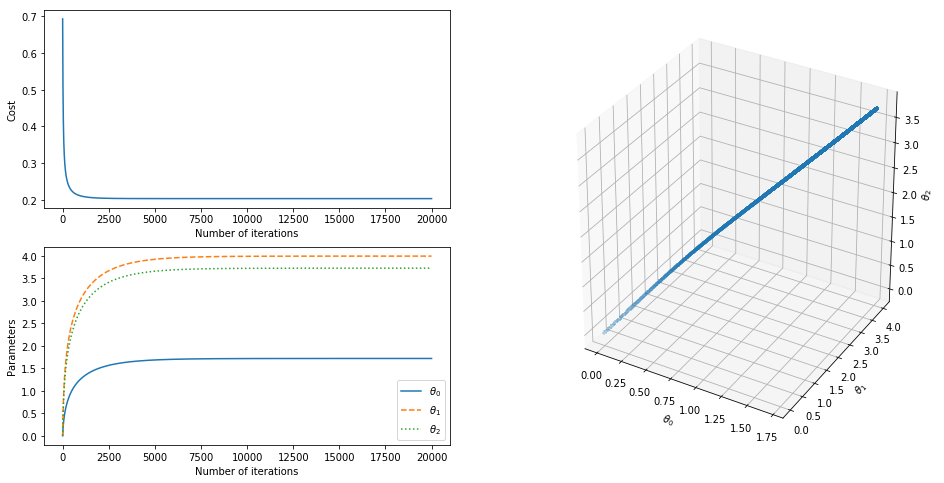

In [26]:
# 勾配法の実行
theta, theta_history, J_history = gradientDescent(X_norm,y,thetai,alpha=0.1,num_iters=20000)
print('勾配法実行後のパラメータ theta =',theta.flatten())

# パラメータ更新ごとのコスト，パラメータをプロット
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(J_history)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = plt.subplot(gs[1,0])
ax2.plot(theta_history[0,:],'-',label=r'$\theta_0$')
ax2.plot(theta_history[1,:],'--',label=r'$\theta_1$')
ax2.plot(theta_history[2,:],':',label=r'$\theta_2$')
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax2.legend()
ax3 = plt.subplot(gs[:,1],projection='3d')
ax3.scatter3D(theta_history[0,:],theta_history[1,:],theta_history[2,:],marker='+')
ax3.set_xlabel(r'$\theta _0$')
ax3.set_ylabel(r'$\theta _1$')
ax3.set_zlabel(r'$\theta _2$')

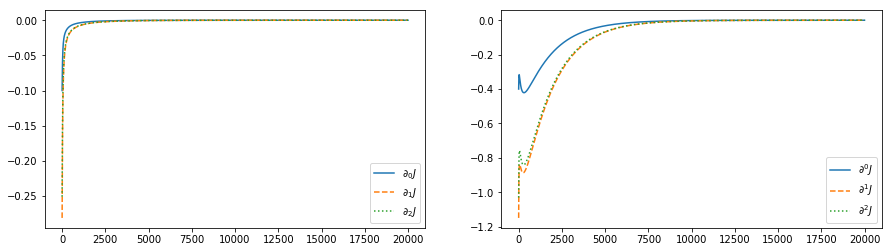

In [27]:
# 勾配法における勾配と自然勾配の計算
_, J_theta_history = costFunction_gradient(X_norm,y,theta_history)
g_inv_history = np.linalg.inv(FisherMatrix(X_norm,theta_history))
J_theta_n_history = np.einsum('tij,jt->it',g_inv_history,J_theta_history)

# プロット
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(121)
ax1.plot(J_theta_history[0,:],'-',label=r'$\partial _0 J$')
ax1.plot(J_theta_history[1,:],'--',label=r'$\partial _1 J$')
ax1.plot(J_theta_history[2,:],':',label=r'$\partial _2 J$')
ax1.legend()
ax2 = fig.add_subplot(122)
ax2.plot(J_theta_n_history[0,:],'-',label=r'$\partial ^0 J$')
ax2.plot(J_theta_n_history[1,:],'--',label=r'$\partial ^1 J$')
ax2.plot(J_theta_n_history[2,:],':',label=r'$\partial ^2 J$')
ax2.legend()

勾配法実行後のパラメータ theta = [1.7174089  3.99056564 3.72298639]


Text(0.5, 0, '$\\theta _2$')

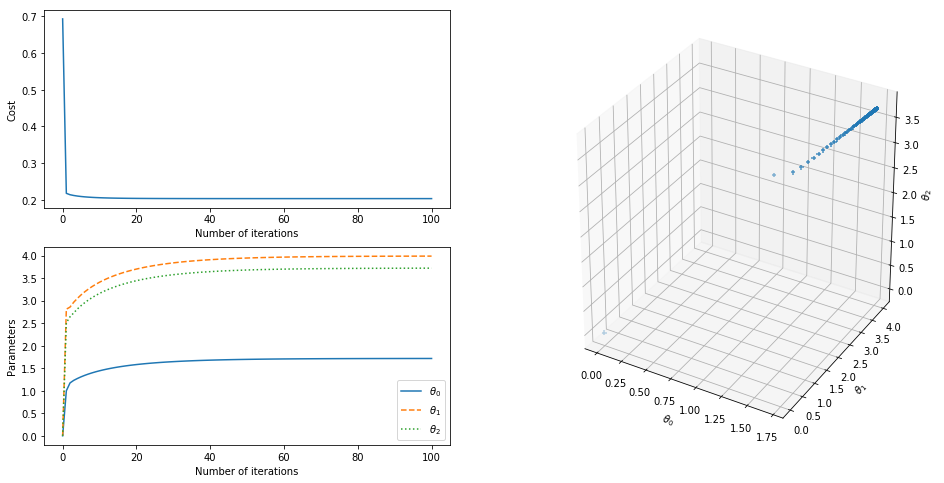

In [28]:
# 勾配法の実行
theta, theta_history, J_history = gradientDescent(X_norm,y,thetai,alpha=10,num_iters=100)
print('勾配法実行後のパラメータ theta =',theta.flatten())

# パラメータ更新ごとのコスト，パラメータをプロット
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(J_history)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = plt.subplot(gs[1,0])
ax2.plot(theta_history[0,:],'-',label=r'$\theta_0$')
ax2.plot(theta_history[1,:],'--',label=r'$\theta_1$')
ax2.plot(theta_history[2,:],':',label=r'$\theta_2$')
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax2.legend()
ax3 = plt.subplot(gs[:,1],projection='3d')
ax3.scatter3D(theta_history[0,:],theta_history[1,:],theta_history[2,:],marker='+')
ax3.set_xlabel(r'$\theta _0$')
ax3.set_ylabel(r'$\theta _1$')
ax3.set_zlabel(r'$\theta _2$')

## パラメータの軌跡の曲率，捩率

再び特徴量が規格化されていない場合を考えよう．学習率$\alpha =10^{-3}$の勾配法で得られるパラメータの軌跡を見ると，初め大きく曲がっている．一方，$\alpha =0.01$の自然勾配法の軌跡はほぼ直線であるように見える．では，勾配法と自然勾配法の軌跡はどれぐらい曲がっているのだろうか．

空間曲線の曲がり具合は曲率によって特徴づけられる．また，曲率と共に曲線を特徴づける量として捩率があり，これは捩れ具合を表したものである．曲率と捩率を勾配法と自然勾配法の軌跡について計算するため，「連続時間極限」（学習率$\alpha$がゼロの極限）を考える．これにより軌跡は連続的な曲線になり，曲率と捩率が定義される．

まず勾配法の連続時間極限を考える．パラメータの更新回数に学習率$\alpha$をかけたものを時間$t$と考えれば，極限$\alpha\to 0$は時間の刻み幅がゼロの極限，すなわち連続時間極限に対応することがわかる．勾配法の連続時間極限は次のように与えられる：
$$
\dot{\theta}_i =-\eta\partial _i J.
$$
ここで，ドットは時間$t$による常微分を表す．$\eta$は連続時間極限における学習率であり，離散時間に戻すためには$\eta\,\Delta t=\alpha$のように定義すればよい．上式の微分方程式から，パラメータの時間による高階微分は解析的に計算できる：
\begin{align}
\ddot{\theta}_i & =\eta ^2 g_{ij} \partial _i J, \\
\dddot{\theta}_i & =-\eta ^3 (g_{ij} g_{jk} \partial _k J+T_{ijk} \partial _j J\,\partial _k J).
\end{align}
上式では添字の上下は区別していないが，Einsteinの縮約規則は用いている．$g_{ij}$はFisher計量であり，$T_{ijk}$はAmari-Chentsovテンソルと呼ばれる：
\begin{align}
g_{ij} & =\mathrm{E} [\sigma 'x_i x_j]=\partial _i \partial _j J, \\
T_{ijk} & =\partial _k g_{ij} =\mathrm{E} [\sigma ''x_i x_j x_k].
\end{align}
ここで，$\mathrm{E} [\cdot ]=\mathrm{E}_{p(x)} [\cdot ]$, $\sigma =\sigma (z)$, $\sigma '=\sigma '(z)$のように略記した．

一方，自然勾配法の連続時間極限は次の微分方程式で与えられる：
$$
\dot{\theta}^i =-\eta g^{ij} \partial _j J.
$$
上式では添字の上下を区別し，Einsteinの縮約規則を用いている．$g^{ij}$はFisher情報行列$g=(g_{ij})$の逆行列$g^{-1}$の$(i,j)$成分である．この微分方程式を用いると，パラメータの時間による高階微分は次のように表される：
\begin{align}
\ddot{\theta}^i & =\eta ^2 (g^{ij} \partial _j J-T^{ijk} \partial _j J\,\partial _k J), \\
\dddot{\theta}^i & =-\eta ^3 \{ g^{ij} \partial _j J-3T^{ijk} \partial _j J\,\partial _k J+[(g^{im} T^{jkn} +2g^{km} T^{ijn})g^{al} T_{amn} -Q^{ijkl}]\partial _j J\,\partial _k J\,\partial _l J\} .
\end{align}
ここで，Amari-Chentsovテンソル$T_{ijk} =\mathrm{E} [\sigma ''x_i x_j x_k]$と4階共変対称テンソル
$$
Q_{ijkl} =\partial _l T_{ijk} =\mathrm{E} [\sigma '''x_i x_j x_k x_l]
$$
を定義し，それらを反変テンソルにしたもの
$$
T^{ijk} =g^{ia} g^{jb} g^{kc} T_{abc} ,\quad Q^{ijkl} =g^{ia} g^{jb} g^{kc} g^{ld} Q_{abcd}
$$
を定義した．

上述のように勾配法もしくは自然勾配法に対してパラメータの3階までの時間導関数を求めれば，軌跡の曲率
$$
\kappa =\frac{\lVert\dot{\theta} \times\ddot{\theta} \rVert}{\lVert\dot{\theta} \rVert ^3}
$$
および捩率
$$
\tau =\frac{(\dot{\theta} \times\ddot{\theta})\cdot\dddot{\theta}}{\lVert\dot{\theta} \times\ddot{\theta} \rVert ^2}
$$
が計算できる．

In [154]:
# 曲率
def curvature(d1theta_dt1,d2theta_dt2):
    kappa = np.zeros(d1theta_dt1.shape[1])
    
    n1 = np.linalg.norm(d1theta_dt1,axis=0)
    I_n1z = (n1 == 0)
    kappa[I_n1z] = np.inf
    
    I_n1nz = ~I_n1z
    d1theta_dt1_norm = np.zeros(d1theta_dt1.shape)
    d1theta_dt1_norm[:,I_n1nz] = d1theta_dt1[:,I_n1nz] / n1[I_n1nz]
    n2 = np.linalg.norm(d2theta_dt2,axis=0)
    I_n2z = (n2 == 0)
    kappa[I_n1nz & I_n2z] = 0
    
    I_n1nzn2nz = I_n1nz & ~I_n2z
    d2theta_dt2_norm = np.zeros(d2theta_dt2.shape)
    d2theta_dt2_norm[:,I_n1nzn2nz] = d2theta_dt2[:,I_n1nzn2nz] / n2[I_n1nzn2nz]
    cross12 = np.cross(d1theta_dt1_norm,d2theta_dt2_norm,axis=0)
    n12 = np.linalg.norm(cross12,axis=0)
    I_n12z = (n12 == 0)
    kappa[I_n1nzn2nz & I_n12z] = 0
    
    I_n1nzn2nzn12nz = I_n1nzn2nz & ~I_n12z
    kappa[I_n1nzn2nzn12nz] = np.exp(- 2 * np.log(n1[I_n1nzn2nzn12nz]) + np.log(n2[I_n1nzn2nzn12nz]) + np.log(n12[I_n1nzn2nzn12nz]))
    
    return(kappa)

In [155]:
# 捩率
def torsion(d1theta_dt1,d2theta_dt2,d3theta_dt3):
    tau = np.zeros(d1theta_dt1.shape[1])
    
    n1 = np.linalg.norm(d1theta_dt1,axis=0)
    I_n1z = (n1 == 0)
    tau[I_n1z] = np.inf
    
    I_n1nz = ~I_n1z
    d1theta_dt1_norm = np.zeros(d1theta_dt1.shape)
    d1theta_dt1_norm[:,I_n1nz] = d1theta_dt1[:,I_n1nz] / n1[I_n1nz]
    n2 = np.linalg.norm(d2theta_dt2,axis=0)
    I_n2z = (n2 == 0)
    tau[I_n1nz & I_n2z] = np.inf
    
    I_n1nzn2nz = I_n1nz & ~I_n2z
    d2theta_dt2_norm = np.zeros(d2theta_dt2.shape)
    d2theta_dt2_norm[:,I_n1nzn2nz] = d2theta_dt2[:,I_n1nzn2nz] / n2[I_n1nzn2nz]
    cross12 = np.cross(d1theta_dt1_norm,d2theta_dt2_norm,axis=0)
    n12 = np.linalg.norm(cross12,axis=0)
    I_n12z = (n12 == 0)
    tau[I_n1nzn2nz & I_n12z] = np.inf
    
    I_n12nz = ~I_n12z
    cross12_norm = np.zeros(cross12.shape)
    cross12_norm[:,I_n12nz] = cross12[:,I_n12nz] / n12[I_n12nz]
    n3 = np.linalg.norm(d3theta_dt3,axis=0)
    I_n3z = (n3 == 0)
    tau[I_n12nz & I_n3z] = 0
    
    I_n12nzn3nz = I_n12nz & ~I_n3z
    d3theta_dt3_norm = np.zeros(d3theta_dt3.shape)
    d3theta_dt3_norm[:,I_n12nzn3nz] = d3theta_dt3[:,I_n12nzn3nz] / n3[I_n12nzn3nz]
    p123 = np.einsum('it,it->t',cross12_norm,d3theta_dt3_norm)
    I_p123z = (p123 == 0)
    tau[I_n12nzn3nz & I_p123z] = 0
    
    I_n12nzn3nzp123nz = I_n12nzn3nz & ~I_p123z
    tau[I_n12nzn3nzp123nz] = np.exp(- np.log(n1[I_n12nzn3nzp123nz]) - np.log(n2[I_n12nzn3nzp123nz])
                                    + np.log(n3[I_n12nzn3nzp123nz]) - np.log(n12[I_n12nzn3nzp123nz])
                                    + np.log(np.abs(p123[I_n12nzn3nzp123nz]))) * np.sign(p123[I_n12nzn3nzp123nz])
    
    return(tau)

In [37]:
# Amari-Chentsovテンソル
def AmariChentsovTensor(X,theta):
    m = X.shape[0]
    h = sigmoid(X @ theta)
    h_d2 = h * (1 - h) * (1 - 2 * h)
    T = (1 / m) * np.einsum('dt,di,dj,dk->tijk',h_d2,X,X,X)
    return(T)

In [38]:
# 4階共変対称テンソル（Amari-Chentsovテンソルの勾配）
def QuarticTensor(X,theta):
    m = X.shape[0]
    h = sigmoid(X @ theta)
    h_d3 = h * (1 - h) * (1 - 6 * h + 6 * h**2)
    Q = (1 / m) * np.einsum('dt,di,dj,dk,dl->tijkl',h_d3,X,X,X,X)
    return(Q)

In [39]:
# 微分方程式ソルバーのインポート
from scipy.integrate import solve_ivp

In [40]:
# 連続時間勾配法
eta = 1
def ContinuousTimeGradientDescent(t,theta_v):
    theta = theta_v.reshape(-1,1)
    m = y.size
    h = sigmoid(X @ theta)
    meta_J_theta = -(eta / m) * (X.T @ (h - y))
    meta_J_theta_v = meta_J_theta.flatten()
    return(meta_J_theta_v)

Text(0.5, 0, '$\\theta _2$')

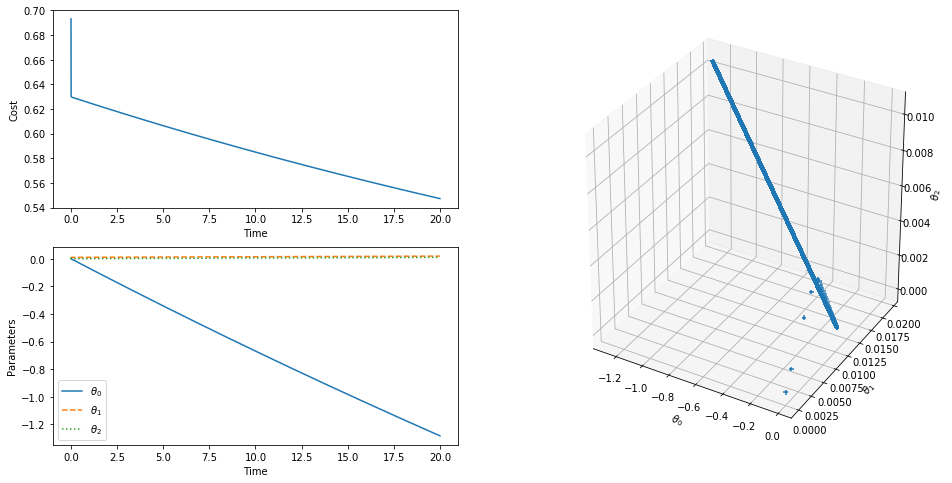

In [144]:
# 連続時間勾配法の実行
ti = 0
tf = 20
sol = solve_ivp(ContinuousTimeGradientDescent,[ti,tf],thetai.flatten(),max_step=0.001)
t_history = sol.t
theta_history = sol.y
J_history, _ = costFunction_gradient(X,y,theta_history)

# コストとパラメータの動きをプロット
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(t_history,J_history)
ax1.set_xlabel('Time')
ax1.set_ylabel('Cost')
ax2 = plt.subplot(gs[1,0])
ax2.plot(t_history,theta_history[0,:],'-',label=r'$\theta_0$')
ax2.plot(t_history,theta_history[1,:],'--',label=r'$\theta_1$')
ax2.plot(t_history,theta_history[2,:],':',label=r'$\theta_2$')
ax2.set_xlabel('Time')
ax2.set_ylabel('Parameters')
ax2.legend()
ax3 = plt.subplot(gs[:,1],projection='3d')
ax3.scatter3D(theta_history[0,:],theta_history[1,:],theta_history[2,:],marker='+')
ax3.set_xlabel(r'$\theta _0$')
ax3.set_ylabel(r'$\theta _1$')
ax3.set_zlabel(r'$\theta _2$')

In [54]:
# 勾配法におけるパラメータの時間導関数（1階から3階まで）
def timeDerivatives3_gradientDescent(X,y,theta,eta):
    J, pJ = costFunction_gradient(X,y,theta)
    
    gl = FisherMatrix(X,theta)
    Tl = AmariChentsovTensor(X,theta)
    
    d1theta_dt1 = -eta * pJ
    d2theta_dt2 = eta**2 * np.einsum('tij,jt->it',gl,pJ)
    d3theta_dt3 = -eta**3 * (np.einsum('tij,tjk,kt->it',gl,gl,pJ) + np.einsum('tijk,jt,kt->it',Tl,pJ,pJ))
    
    return(d1theta_dt1,d2theta_dt2,d3theta_dt3)

Text(0, 0.5, 'Torsion')

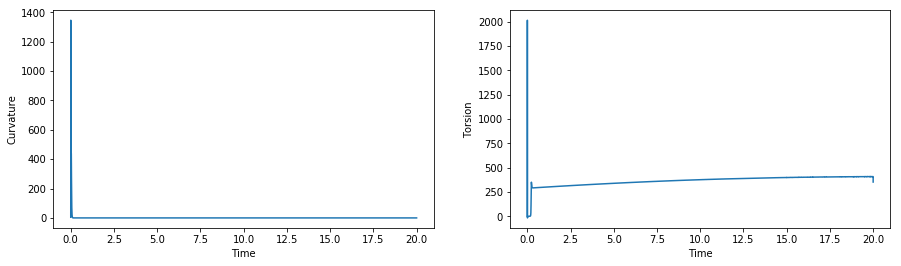

In [145]:
# パラメータの時間導関数
d1theta_dt1_history, d2theta_dt2_history, d3theta_dt3_history = timeDerivatives3_gradientDescent(X,y,theta_history,eta)

# 曲率と捩率
kappa_history = curvature(d1theta_dt1_history,d2theta_dt2_history)
tau_history = torsion(d1theta_dt1_history,d2theta_dt2_history,d3theta_dt3_history)

# 曲率と捩率のプロット
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(121)
ax1.plot(t_history,kappa_history)
ax1.set_xlabel('Time')
ax1.set_ylabel('Curvature')
ax2 = fig.add_subplot(122)
ax2.plot(t_history,tau_history)
ax2.set_xlabel('Time')
ax2.set_ylabel('Torsion')

In [56]:
# 連続時間自然勾配法
eta = 1
def ContinuousTimeNaturalGradientDescent(t,theta_v):
    theta = theta_v.reshape(-1,1)
    m = y.size
    h = sigmoid(X @ theta)
    meta_J_theta = -(eta / m) * X.T @ (h - y)
    g_inv = np.linalg.inv(FisherMatrix(X,theta))
    meta_J_theta_n = np.einsum('tij,jt->it',g_inv,meta_J_theta)
    meta_J_theta_n_v = meta_J_theta_n.flatten()
    return(meta_J_theta_n_v)

Text(0.5, 0, '$\\theta _2$')

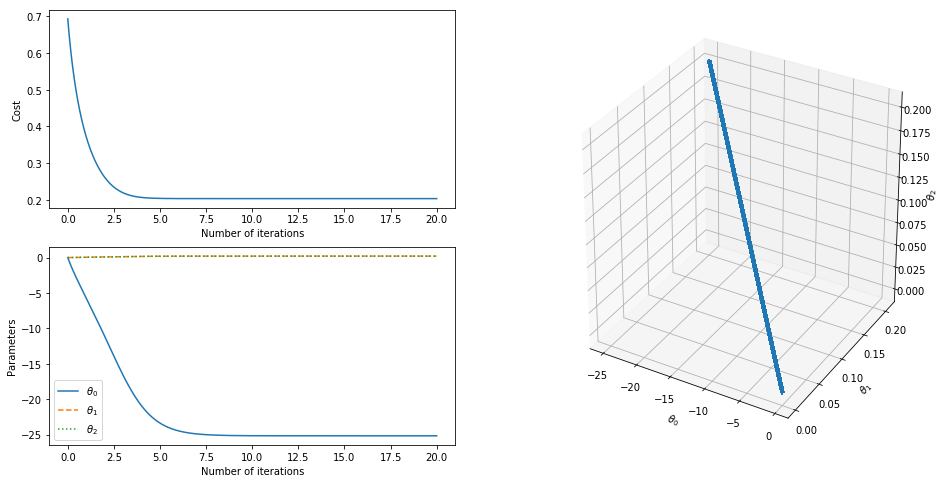

In [152]:
# 連続時間自然勾配法の実行
ti = 0
tf = 20
sol = solve_ivp(ContinuousTimeNaturalGradientDescent,[ti,tf],thetai.flatten(),max_step=0.001)
t_history = sol.t
theta_history = sol.y
J_history, J_theta_history = costFunction_gradient(X,y,theta_history)

# コストとパラメータの動きをプロット
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(t_history,J_history)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = plt.subplot(gs[1,0])
ax2.plot(t_history,theta_history[0,:],'-',label=r'$\theta_0$')
ax2.plot(t_history,theta_history[1,:],'--',label=r'$\theta_1$')
ax2.plot(t_history,theta_history[2,:],':',label=r'$\theta_2$')
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax2.legend()
ax3 = plt.subplot(gs[:,1],projection='3d')
ax3.scatter3D(theta_history[0,:],theta_history[1,:],theta_history[2,:],marker='+')
ax3.set_xlabel(r'$\theta _0$')
ax3.set_ylabel(r'$\theta _1$')
ax3.set_zlabel(r'$\theta _2$')

In [58]:
# 自然勾配法におけるパラメータの時間導関数（1階から3階まで）
def timeDerivatives3_naturalGradientDescent(X,y,theta,eta):
    J, pJ = costFunction_gradient(X,y,theta)
    
    gl = FisherMatrix(X,theta)
    gu = np.linalg.inv(gl)
    Tl = AmariChentsovTensor(X,theta)
    Tu = np.einsum('tia,tjb,tkc,tabc->tijk',gu,gu,gu,Tl)
    Ql = QuarticTensor(X,theta)
    Qu = np.einsum('tia,tjb,tkc,tld,tabcd->tijkl',gu,gu,gu,gu,Ql)
    
    gu_pJ = np.einsum('tij,jt->it',gu,pJ)
    Tu_pJ_pJ = np.einsum('tijk,jt,kt->it',Tu,pJ,pJ)
    gu_Tu = np.einsum('tij,tklm->tijklm',gu,Tu)
    gu_Tl = np.einsum('tai,tajk->tijk',gu,Tl)
    ru = np.einsum('timjkn,tlmn->tijkl',gu_Tu,gu_Tl) + 2 * np.einsum('tkmijn,tlmn->tijkl',gu_Tu,gu_Tl) - Qu
    ru_pJ_pJ_pJ = np.einsum('tijkl,jt,kt,lt->it',ru,pJ,pJ,pJ)
    
    d1theta_dt1 = -eta * gu_pJ
    d2theta_dt2 = eta**2 * (gu_pJ - Tu_pJ_pJ)
    d3theta_dt3 = -eta**3 * (gu_pJ - 3 * Tu_pJ_pJ + ru_pJ_pJ_pJ)
    
    return(d1theta_dt1,d2theta_dt2,d3theta_dt3)

Text(0, 0.5, 'Torsion')

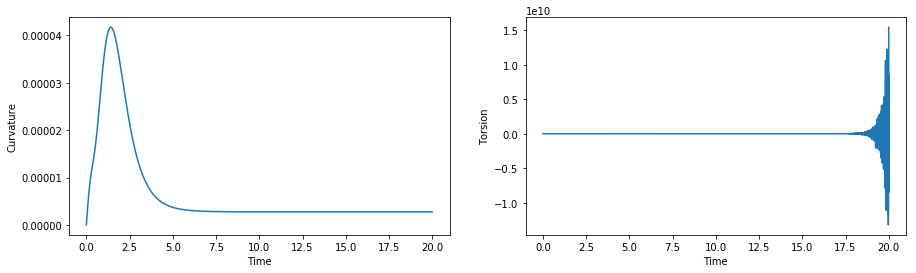

In [156]:
# パラメータの時間導関数
d1theta_dt1_history, d2theta_dt2_history, d3theta_dt3_history = timeDerivatives3_naturalGradientDescent(X,y,theta_history,eta)

# 曲率と捩率
kappa_history = curvature(d1theta_dt1_history,d2theta_dt2_history)
tau_history = torsion(d1theta_dt1_history,d2theta_dt2_history,d3theta_dt3_history)

# 曲率と捩率のプロット
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(121)
ax1.plot(t_history,kappa_history)
ax1.set_xlabel('Time')
ax1.set_ylabel('Curvature')
ax2 = fig.add_subplot(122)
ax2.plot(t_history,tau_history)
ax2.set_xlabel('Time')
ax2.set_ylabel('Torsion')